##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 贝叶斯高斯混合模型与汉密尔顿 MCMC

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

在此 Colab 中，我们将仅使用 TensorFlow Probability 基元探索从贝叶斯高斯混合模型 (BGMM) 的后验中进行采样。

## 模型

对于每个维度 $D$ 的 $k\in{1,\ldots, K}$ 混合分量，我们希望使用以下贝叶斯高斯混合模型对 $i\in{1,\ldots,N}$ iid 样本进行建模：

$$\begin{align*} \theta &amp;\sim \text{Dirichlet}(\text{concentration}=\alpha_0)\ \mu_k &amp;\sim \text{Normal}(\text{loc}=\mu_{0k}, \text{scale}=I_D)\ T_k &amp;\sim \text{Wishart}(\text{df}=5, \text{scale}=I_D)\ Z_i &amp;\sim \text{Categorical}(\text{probs}=\theta)\ Y_i &amp;\sim \text{Normal}(\text{loc}=\mu_{z_i}, \text{scale}=T_{z_i}^{-1/2})\ \end{align*}$$

请注意，`scale` 参数都具有 `cholesky` 语义。我们使用此约定是因为它是 TF 分布（它本身使用此约定，部分原因是它在计算上具有优势）的约定。

我们的目标是从后验生成样本：

$$p\left(\theta, {\mu_k, T_k}*{k=1}^K \Big| {y_i}*{i=1}^N, \alpha_0, {\mu_{ok}}_{k=1}^K\right)$$

请注意不存在 ${Z_i}_{i=1}^N$，我们只对不会随 $N$ 缩放的随机变量感兴趣。（幸运的是，存在一个 TF 分布可以处理 $Z_i$ 的边缘化。）

由于存在一个难以在计算上归一化的项，因此无法直接从该分布中采样。

[梅特罗波利斯-黑斯廷斯算法](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)是一种用于从难以归一化的分布进行采样的技术。

TensorFlow Probability 提供了许多 MCMC 选项，其中包括一些基于梅特罗波利斯-黑斯廷斯算法的选项。在此笔记本中，我们将使用[汉密尔顿蒙特卡洛算法](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) (`tfp.mcmc.HamiltonianMonteCarlo`)。HMC 通常是一个不错的选择，因为它可以快速收敛、可以对状态空间进行联合采样（相对于协调方式），还可以利用 TF 的其中一个优点：自动微分。即便如此，实际上通过其他方式（例如[吉布斯采样](https://en.wikipedia.org/wiki/Gibbs_sampling)）可能可以更好地完成从 BGMM 后验分布的采样。

In [ ]:
%matplotlib inline


import functools

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import seaborn as sns; sns.set_context('notebook')

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

在实际构建模型之前，我们需要定义一种新的分布类型。从上面的模型规范中可以明显看出，我们在使用逆协方差矩阵对 MVN 进行参数化，即[精度矩阵] (https://en.wikipedia.org/wiki/Precision_(statistics%29))。为了在 TF 中实现此操作，我们需要推出 `Bijector`。这个 `Bijector` 将使用前向转换：

- `Y =  tf.linalg.triangular_solve((tf.linalg.matrix_transpose(chol_precision_tril), X, adjoint=True) + loc`

`log_prob` 正好相反，即：

- `X = tf.linalg.matmul(chol_precision_tril, X - loc, adjoint_a=True)`

由于 HMC 只需 `log_prob`，这意味着我们会避免调用 `tf.linalg.triangular_solve`（与 `tfd.MultivariateNormalTriL` 一样）。这样做有优势，因为由于缓存位置更好，`tf.linalg.matmul` 通常更快。


In [ ]:
class MVNCholPrecisionTriL(tfd.TransformedDistribution):
  """MVN from loc and (Cholesky) precision matrix."""

  def __init__(self, loc, chol_precision_tril, name=None):
    super(MVNCholPrecisionTriL, self).__init__(
        distribution=tfd.Independent(tfd.Normal(tf.zeros_like(loc),
                                                scale=tf.ones_like(loc)),
                                     reinterpreted_batch_ndims=1),
        bijector=tfb.Chain([
            tfb.Shift(shift=loc),
            tfb.Invert(tfb.ScaleMatvecTriL(scale_tril=chol_precision_tril,
                                           adjoint=True)),
        ]),
        name=name)

`tfd.Independent` 分布会将一个分布的独立图表转变为具有统计独立坐标的多元分布。就计算 `log_prob` 而言，此“元分布”表现为事件维度上的简单总和。

另请注意，我们接受缩放矩阵的 `adjoint`（“转置”）。这是因为如果精确率是逆协方差，即 $P=C^{-1}$，并且如果 $C=AA^\top$，则 $P=BB^{\top}$，其中 $B=A^{-\top}$。

由于这种分布不好处理，让我们来快速验证一下 `MVNCholPrecisionTriL` 是否能够按照我们的预期工作。

In [ ]:
def compute_sample_stats(d, seed=42, n=int(1e6)):
  x = d.sample(n, seed=seed)
  sample_mean = tf.reduce_mean(x, axis=0, keepdims=True)
  s = x - sample_mean
  sample_cov = tf.linalg.matmul(s, s, adjoint_a=True) / tf.cast(n, s.dtype)
  sample_scale = tf.linalg.cholesky(sample_cov)
  sample_mean = sample_mean[0]
  return [
      sample_mean,
      sample_cov,
      sample_scale,
  ]

dtype = np.float32
true_loc = np.array([1., -1.], dtype=dtype)
true_chol_precision = np.array([[1., 0.],
                                [2., 8.]],
                               dtype=dtype)
true_precision = np.matmul(true_chol_precision, true_chol_precision.T)
true_cov = np.linalg.inv(true_precision)

d = MVNCholPrecisionTriL(
    loc=true_loc,
    chol_precision_tril=true_chol_precision)

[sample_mean, sample_cov, sample_scale] = [
    t.numpy() for t in compute_sample_stats(d)]

print('true mean:', true_loc)
print('sample mean:', sample_mean)
print('true cov:\n', true_cov)
print('sample cov:\n', sample_cov)

true mean: [ 1. -1.]
sample mean: [ 1.0002806 -1.000105 ]
true cov:
 [[ 1.0625   -0.03125 ]
 [-0.03125   0.015625]]
sample cov:
 [[ 1.0641273  -0.03126175]
 [-0.03126175  0.01559312]]


由于样本均值和协方差接近真实均值和协方差，因此似乎分布已正确实现。现在，我们将使用 `MVNCholPrecisionTriL` `tfp.distributions.JointDistributionNamed` 来指定 BGMM 模型。对于观察模型，我们将使用 `tfd.MixtureSameFamily` 自动集成 ${Z_i}_{i=1}^N$ 绘图。

In [ ]:
dtype = np.float64
dims = 2
components = 3
num_samples = 1000

In [ ]:
bgmm = tfd.JointDistributionNamed(dict(
  mix_probs=tfd.Dirichlet(
    concentration=np.ones(components, dtype) / 10.),
  loc=tfd.Independent(
    tfd.Normal(
        loc=np.stack([
            -np.ones(dims, dtype),
            np.zeros(dims, dtype),
            np.ones(dims, dtype),
        ]),
        scale=tf.ones([components, dims], dtype)),
    reinterpreted_batch_ndims=2),
  precision=tfd.Independent(
    tfd.WishartTriL(
        df=5,
        scale_tril=np.stack([np.eye(dims, dtype=dtype)]*components),
        input_output_cholesky=True),
    reinterpreted_batch_ndims=1),
  s=lambda mix_probs, loc, precision: tfd.Sample(tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=mix_probs),
      components_distribution=MVNCholPrecisionTriL(
          loc=loc,
          chol_precision_tril=precision)),
      sample_shape=num_samples)
))

In [ ]:
def joint_log_prob(observations, mix_probs, loc, chol_precision):
  """BGMM with priors: loc=Normal, precision=Inverse-Wishart, mix=Dirichlet.

  Args:
    observations: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian
      Mixture model draws. Each sample is a length-`d` vector.
    mix_probs: `[K]`-shaped `Tensor` representing random draw from
      `Dirichlet` prior.
    loc: `[K, d]`-shaped `Tensor` representing the location parameter of the
      `K` components.
    chol_precision: `[K, d, d]`-shaped `Tensor` representing `K` lower
      triangular `cholesky(Precision)` matrices, each being sampled from
      a Wishart distribution.

  Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.
  """
  return bgmm.log_prob(
      mix_probs=mix_probs, loc=loc, precision=chol_precision, s=observations)

## 生成“训练”数据

对于此演示，我们将对一些随机数据进行采样。

In [ ]:
true_loc = np.array([[-2., -2],
                     [0, 0],
                     [2, 2]], dtype)
random = np.random.RandomState(seed=43)

true_hidden_component = random.randint(0, components, num_samples)
observations = (true_loc[true_hidden_component] +
                random.randn(num_samples, dims).astype(dtype))

## 使用 HMC 的贝叶斯推断

现在，我们已经使用了 TFD 来指定我们的模型并获得了一些观察到的数据，我们已经具备了运行 HMC 所需的所有部件。

为此，我们将使用[部分应用](https://en.wikipedia.org/wiki/Partial_application)来“固定”我们不想采样的内容。在本例中，这意味着我们只需要固定 `observations`。（超参数已烘焙到先验分布中，而不是 `joint_log_prob` 函数签名的一部分。）

In [ ]:
unnormalized_posterior_log_prob = functools.partial(joint_log_prob, observations)

In [ ]:
initial_state = [
    tf.fill([components],
            value=np.array(1. / components, dtype),
            name='mix_probs'),
    tf.constant(np.array([[-2., -2],
                          [0, 0],
                          [2, 2]], dtype),
                name='loc'),
    tf.linalg.eye(dims, batch_shape=[components], dtype=dtype, name='chol_precision'),
]

### 无约束表示

汉密尔顿蒙特卡洛 (HMC) 要求目标对数概率函数的参数可微。此外，如果状态空间无约束，则 HMC 可以显著提高统计效率。

这意味着从 BGMM 后验进行采样时，我们必须解决两个主要问题：

1. $\theta$ 表示离散概率向量，即必须使 $\sum_{k=1}^K \theta_k = 1$ 且 $\theta_k&gt;0$。
2. $T_k$ 表示逆协方差矩阵，即必须使 $T_k \succ 0$（即为[正定](https://en.wikipedia.org/wiki/Positive-definite_matrix)。


为了满足此要求，我们需要：

1. 将约束变量转换为无约束空间
2. 在无约束空间中运行 MCMC
3. 将无约束变量转换回约束空间

至于 `MVNCholPrecisionTriL`，我们将使用 [`Bijector`](https://www.tensorflow.org/api_docs/python/tf/distributions/bijectors/Bijector) 将随机变量转换为无约束空间。

- [`Dirichlet`](https://en.wikipedia.org/wiki/Dirichlet_distribution) 通过 [Softmax 函数](https://en.wikipedia.org/wiki/Softmax_function)转换为无约束空间。

- 我们的精确率随机变量是半正定矩阵上的分布。为了取消约束，我们将使用 `FillTriangular` 和 `TransformDiagonal` 双射器。这些会将向量转换为下三角矩阵，并确保对角线为正。前者很有用，因为它可以仅对 $d(d+1)/2$ 浮点进行采样，而非 $d^2$。

In [ ]:
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.Identity(),
    tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus()),
        tfb.FillTriangular(),
    ])]

In [ ]:
@tf.function(autograph=False)
def sample():
  return tfp.mcmc.sample_chain(
    num_results=2000,
    num_burnin_steps=500,
    current_state=initial_state,
    kernel=tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_posterior_log_prob,
                 step_size=0.065,
                 num_leapfrog_steps=5),
            bijector=unconstraining_bijectors),
         num_adaptation_steps=400),
    trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

[mix_probs, loc, chol_precision], is_accepted = sample()

现在，我们将执行链并打印后验均值。

In [ ]:
acceptance_rate = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32)).numpy()
mean_mix_probs = tf.reduce_mean(mix_probs, axis=0).numpy()
mean_loc = tf.reduce_mean(loc, axis=0).numpy()
mean_chol_precision = tf.reduce_mean(chol_precision, axis=0).numpy()
precision = tf.linalg.matmul(chol_precision, chol_precision, transpose_b=True)


In [ ]:
print('acceptance_rate:', acceptance_rate)
print('avg mix probs:', mean_mix_probs)
print('avg loc:\n', mean_loc)
print('avg chol(precision):\n', mean_chol_precision)

acceptance_rate: 0.5305
avg mix probs: [0.25248723 0.60729516 0.1402176 ]
avg loc:
 [[-1.96466753 -2.12047249]
 [ 0.27628865  0.22944732]
 [ 2.06461244  2.54216122]]
avg chol(precision):
 [[[ 1.05105032  0.        ]
  [ 0.12699955  1.06553113]]

 [[ 0.76058015  0.        ]
  [-0.50332767  0.77947431]]

 [[ 1.22770457  0.        ]
  [ 0.70670027  1.50914164]]]


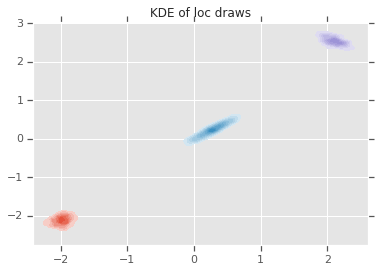

In [ ]:
loc_ = loc.numpy()
ax = sns.kdeplot(loc_[:,0,0], loc_[:,0,1], shade=True, shade_lowest=False)
ax = sns.kdeplot(loc_[:,1,0], loc_[:,1,1], shade=True, shade_lowest=False)
ax = sns.kdeplot(loc_[:,2,0], loc_[:,2,1], shade=True, shade_lowest=False)
plt.title('KDE of loc draws');

## 结论

这个简单的 Colab 演示了如何将 TensorFlow Probability 基元用于构建分层贝叶斯混合模型。